# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: [https://colab.research.google.com/github/GreatArcStudios/APS360/blob/master/Lab%205/Lab5%20Spam%20Detection.ipynb](https://colab.research.google.com/github/GreatArcStudios/APS360/blob/master/Lab%205/Lab5%20Spam%20Detection.ipynb)

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

In [166]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [167]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchtext
from torchinfo import summary 
print(torchtext.__version__)

0.9.0


## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [168]:
i = 0
for line in open('SMSSpamCollection'):
    if i < 5:  
        line = line.split("\t")
        print(line)
    else:
        break
    i+=1 


['ham', 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n']
['ham', 'Ok lar... Joking wif u oni...\n']
['spam', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n"]
['ham', 'U dun say so early hor... U c already then say...\n']
['ham', "Nah I don't think he goes to usf, he lives around here though\n"]


A spam message has the label `spam`, and the non-spam message has a label `ham`. 

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [169]:
spam_count, ham_count = 0, 0
for line in open("SMSSpamCollection"):
    line = line.split("\t")
    if line[0] == "spam":
        spam_count += 1
    else:
        ham_count += 1
print(f"Spam Count: {spam_count} | Ham Count {ham_count}")

Spam Count: 747 | Ham Count 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages: 
1. If we model the character-level relationship we could potentially induce more diversity into text generation since we learn a distribution over characters. This means the model does not just have to produce outputs contained in the vocabulary, e.g., one full word in the vocabulary/corpus at a time. 
2. Since there are only 26 characters in the English alphabet (and similar amounts if we consider the Latin alphabet more broadly), the model only has to learn a much smaller dimension corpus/vocabulary than a word level-model, which would need to learn many words in order to produce sensible outputs. 

Disadvantages: 
1. If we predict the most likely next character, we can get non-existent words as outputs. We do not guarantee that outputs have to be valid words since we don't actually learn that. 
2. We may have to increase the sentence/output length since words are comprised of many characters, so to get a meaningfully long sentence (instead of something like "the sky is blue") we would need to increase the number of output tokens to account for longer words and more words. 

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [228]:
text_field = torchtext.legacy.data.Field(batch_first=True, 
                                         tokenize=list)
label_field = torchtext.legacy.data.LabelField(batch_first=True,
                                               preprocessing=lambda x: float(x == "spam"),
                                               dtype=torch.float)
spam_ham_dataset = torchtext.legacy.data.TabularDataset(
    path="SMSSpamCollection", format="tsv", fields=[("label", label_field), ("sms", text_field)])


In [268]:
train, val, test = spam_ham_dataset.split(split_ratio=[0.6, 0.2, 0.2])

In [267]:
#[e.label for e in val.examples]

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [269]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In this case, having a big data imbalance means that the model can achieve high accuracy simply by predicting (classifying) everything as not spam, which is what minimizing the loss will help us achieve (minimizing loss helps maximize accuracy). So if we suppose that the model achieved high accuracy by classifying most examples as not spam then, we could expect to see a high false negative rate, which could be problematic if spam messages have harmful content like phishing links. 

In [270]:
# Sanity check
print(len([e for e in train.examples if e.label==1]), len([e for e in train.examples if e.label==0]))

3150 2893


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [271]:
text_field.build_vocab(train)
label_field.build_vocab(train)

In [ ]:
#text_field.vocab.stoi

In [ ]:
#text_field.vocab.itos

Going off of the official `torchtext` [docs](https://torchtext.readthedocs.io/en/latest/vocab.html), `text_field.vocab.stoi` gives us "a collections.defaultdict instance mapping token strings to numerical identifiers", while `text_field.vocab.itos` gives us "a list of token strings indexed by their numerical identifiers". The `stoi` attribute then gives us an easy way retrieve the index of a work in the vocab, e.g., `<unk>` has an index of 0. On the other side, `itos` is a list of the tokens at their respective index, e.g., `<unk>` is *at* index 0 in the list, which matches with its value in the `stoi` dictionary. 

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` and `<pad>` tokens correspond to the unknown word w.r.t the vocab (e.g., a unique and very uncommon username) and a meaningless padding token to make shorter examples the same length respectively. The latter can help with parallelization. 

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [273]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [276]:
batch_count = 0 
max_lengths = []
pad_counts = []
dummy_example = None
dummy_label = None
for batch in train_iter:
    if batch_count < 10: 
        # print(len(batch))
        # print(batch.sms)
        # print(batch.label)
        max_length, pad_count = 0, 0 
        pad_idx = text_field.vocab.stoi["<pad>"]
        for example in batch.sms:
            max_length = max(len(example), max_length)
            pad_count += torch.count_nonzero(example == pad_idx)
        max_lengths.append(max_length)
        pad_counts.append(int(pad_count))
    else: 
        ident = torch.eye(len(text_field.vocab.itos))
        print(batch.sms.shape, batch.label.shape)
        dummy_example = ident[batch.sms]
        dummy_label = batch.label
        print(batch.sms[0])
        break
    batch_count += 1 

torch.Size([32, 97]) torch.Size([32])
tensor([48,  3, 10, 10,  6, 22,  3,  2, 24,  8,  4, 18,  2, 16,  2, 37,  2,  6,
        18,  2,  6,  5,  2, 27,  8, 12,  8,  4,  2, 53,  4, 10, 21,  9,  5,  6,
        11,  2,  4,  7,  2,  3, 42,  5, 16,  2, 57,  4, 12,  2, 17,  6,  7,  2,
        21, 13,  4,  7,  3,  2, 18,  3,  2, 13,  3,  8,  3, 16,  2,  6, 10,  2,
        37,  2, 13,  6, 30,  3,  2,  6,  2, 21, 13,  4,  7,  3,  2, 25, 19,  2,
        18, 19,  2, 10,  9, 15,  3])


We can see below that the counts of the max lengths of the training examples in each batch and their respective pad counts. We can see that each batch varying maximum lengths ranging from well under 100 to well over 100. The pad counts varied from 0 to over 100 over various different batches (runs of the above for loop). 

In [275]:
print(max_lengths, pad_counts)

[48, 124, 101, 32, 53, 28, 152, 161, 35, 30] [38, 68, 77, 36, 44, 17, 22, 18, 13, 8]


In [237]:
dummy_example.shape 

torch.Size([32, 158, 117])

In [238]:
dummy_label

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [239]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch   .tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [293]:
class SimpleRNN(nn.Module):
    def __init__(self, corpus_size, hidden_size, n_layers=5):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size=corpus_size,
                          hidden_size=hidden_size, 
                          num_layers=n_layers,
                          batch_first=True)
        self.classification_head = nn.Sequential(
            nn.Linear(2*hidden_size, 4*hidden_size),
            nn.GELU(),
            nn.Linear(4*hidden_size, hidden_size),
            nn.GELU(),
        )
        self.residual = nn.Sequential(
            nn.Linear(2*hidden_size, hidden_size)
        )
        self.fc_out = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, 1)
        )  # either spam or not
        self.simple_out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        max_pool = torch.max(rnn_out, dim=1)[0]
        avg_pool = torch.mean(rnn_out, dim=1)
        rnn_out = torch.cat([max_pool, avg_pool], dim=1)
        head_out = self.classification_head(rnn_out)
        residual_out = self.residual(rnn_out)
        out = head_out + residual_out
        return self.fc_out(out)


## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [300]:
def get_accuracy(model, data, corpus_size, device):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid, corpus_size, device) # the variable `valid` is from above
    """
    with torch.no_grad():
        num_correct, num_total = 0, 0 
        ident = torch.eye(corpus_size).to(device)
        for batch in data: 
            label = batch.label.to(device)
            sms = batch.sms
            data_processed = ident[sms]
            pred = model(data_processed)
            pred = nn.functional.sigmoid(pred).reshape(-1)
            pred = (pred>=0.5).float().to(device)
            num_correct += torch.sum(pred == label)
            num_total += len(pred)
    return num_correct/num_total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [353]:
from matplotlib import pyplot as plt 
def plot_acc_curves(loss_dict):
    plt.title(f"{loss_dict['config']}")
    plt.plot([value for value in loss_dict["epochs"]], [value.cpu().data.numpy() for value in  loss_dict["train_acc"]], label="Train Accuracy")
    plt.plot([value for value in loss_dict["epochs"]], [value.cpu().data.numpy() for value in  loss_dict["val_acc"]], label="Validation Accuracy")
    plt.xlabel(f"{len(loss_dict['epochs'])} Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def plot_loss_curves(loss_dict):
    plt.title(f"{loss_dict['config']}")
    plt.plot([value for value in loss_dict["epochs"]], [value.cpu().data.numpy() for value in loss_dict["train_loss"]], label="Train Loss")
    plt.plot([value for value in loss_dict["epochs"]], [value.cpu().data.numpy() for value in loss_dict["val_loss"]], label="Validation Loss")
    plt.xlabel(f"{len(loss_dict['epochs'])} Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [307]:
def train_loop(model, train_loader, valid_loader, corpus_size=32, num_epochs=5, learning_rate=1e-4, val_epochs=10, weight_decay=1e-6, acc_func=None, use_cuda=True, model_path_prefix="./models/", plot_acc=False):
    torch.manual_seed(100)

    # determine if CUDA is available and set Tensor core flags
    if use_cuda and torch.cuda.is_available():
        dev = "cuda:0"
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    else:
        print("CUDA unavailable, training on CPU")
        dev = "CPU"
    device = torch.device(dev)
    model = model.to(device)

    best_val_loss = float('inf')

    loss_dict = {"config": f"Epochs: {num_epochs}, Lr: {learning_rate}",
                 "epochs": [],
                 "train_loss": [], "val_loss": [],
                 "train_acc": [], "val_acc": []}

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    ident = torch.eye(corpus_size).to(device)
    for epoch in range(num_epochs):
        train_loss = 0.0
        batches = 0

        for data in train_loader:
            sms, label = data.sms, data.label.reshape(-1, 1).to(device)
            data_processed = ident[sms]
            # use Nvidia AMP for tensor cores speed up.
            with torch.cuda.amp.autocast():
                pred = model(data_processed)
                loss = criterion(pred, label)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss
            batches += 1


        train_loss /= batches

        if epoch % val_epochs == 0:
            with torch.no_grad():
                val_acc = 0.0
                train_acc = 0.0
                val_loss = 0.0
                for data in valid_loader:
                    sms, label = data.sms, data.label.reshape(-1, 1).to(device)

                    data_processed = ident[sms]
                    preds = model(data_processed)
                    val_loss += criterion(preds, label)
                print(
                    f"epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}")
                if plot_acc:
                    val_acc = acc_func(model, valid_loader,
                                       corpus_size, device)
                    train_acc = acc_func(
                        model, train_loader, corpus_size, device)
                    print(
                        f"epoch: {epoch}, train_acc: {train_acc}, val_acc: {val_acc}")

                loss_dict["train_loss"].append(train_loss)
                loss_dict["val_loss"].append(val_loss)
                loss_dict["train_acc"].append(train_acc)
                loss_dict["val_acc"].append(val_acc)
                loss_dict["epochs"].append(epoch)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), model_path_prefix +
                               f"valloss-{np.round(best_val_loss.cpu().numpy(), decimals=4)}-lr_{learning_rate}-epoch_num_{epoch}.mdlckpt")

    return model, loss_dict


In [325]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

val_iter = torchtext.legacy.data.BucketIterator(val,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs


In [308]:
SpamClassifier = SimpleRNN(corpus_size = len(text_field.vocab.itos), hidden_size=200)
model, loss_dict = train_loop(SpamClassifier, train_iter, val_iter, len(text_field.vocab.itos), num_epochs=50, acc_func=get_accuracy, plot_acc=True)

epoch: 0, train_loss: 0.6935163140296936, val_loss: 24.860689163208008
epoch: 0, train_acc: 0.5212643146514893, val_acc: 0.13273541629314423
epoch: 10, train_loss: 0.11180739849805832, val_loss: 4.6100568771362305
epoch: 10, train_acc: 0.9624359011650085, val_acc: 0.9452914595603943
epoch: 20, train_loss: 0.06319965422153473, val_loss: 3.1552038192749023
epoch: 20, train_acc: 0.9766672253608704, val_acc: 0.9677129983901978
epoch: 30, train_loss: 0.041549183428287506, val_loss: 3.7731552124023438
epoch: 30, train_acc: 0.979314923286438, val_acc: 0.963228702545166
epoch: 40, train_loss: 0.030243732035160065, val_loss: 3.4513604640960693
epoch: 40, train_acc: 0.9963594675064087, val_acc: 0.9829596281051636


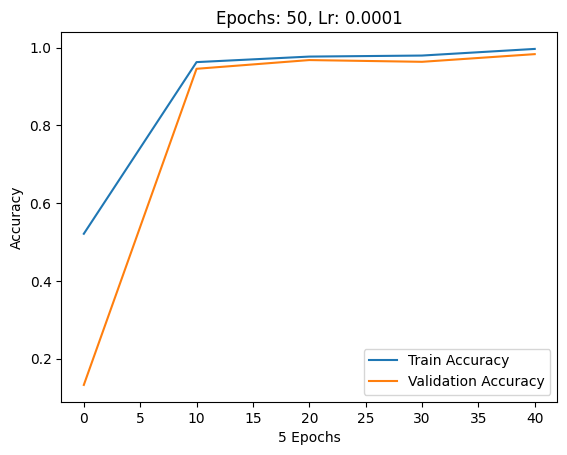

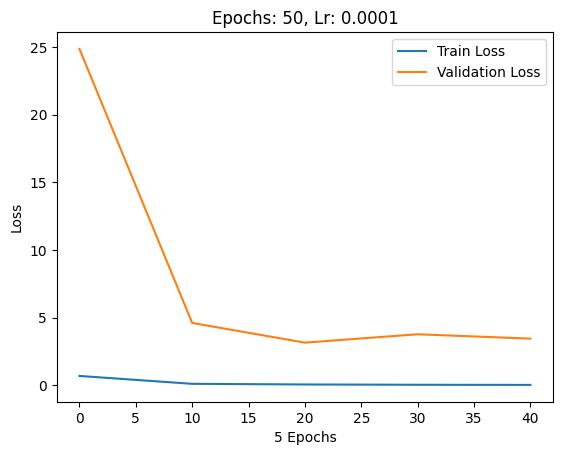

In [354]:
plot_acc_curves(loss_dict)
plot_loss_curves(loss_dict)

In [306]:
val_acc = get_accuracy(model, val_iter, len(text_field.vocab.itos), "cuda:0")
val_acc

c:\ProgramData\Anaconda3\envs\pytorch-torchtext\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.9830, device='cuda:0')

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In this section, we will consider the `num_layer`, `hidden_size`, `learning_rate`, and `weight_decay` parameters. We will also run the better hyperparameter through some further tuned hyperparameters using the better hyperparameter set as a starting line. Overall, we will approach hyperparameter tuning from a grid search like approach. First, we consider a low amount of layers with a small hidden size to examine a smaller network with a higher learning rate and low weight decay to examine the effects of a smaller network that is "easier" to train (consider that we do not need a larger weight decay if the network is less complex because less penalization for the network is required). So for this first set, we consider `num_layer = 2`, `hidden_size = 50`, `learning_rate = 5e-4`, and `weight_decay=1e-6`. Second, we will consider a high amount of layers with a large hidden size and a lower learning rate and higher weight decay. So we can consider the following for the second set: `num_layer = 10`, `hidden_size = 300`, `learning_rate = 8e-5`, and `weight_decay=1e-4`. Then for the 3rd set, we approach it through the grid search approach, so we will consider a low amount of layers with a small hidden size with a lower learning rate and higher weight decay, so we can consider: `num_layer = 2`, `hidden_size = 50`, `learning_rate = 8e-5`, and `weight_decay=1e-4`. Finally, we can also consider a high amount of layers with a large hidden size and a higher learning rate and lower weight decay: `num_layer = 10`, `hidden_size = 300`, `learning_rate = 5e-4`, and `weight_decay=1e-6`.

In [338]:
low_lr = 4e-4 
high_lr = 6e-4

low_wd = 1e-6
high_wd = 3e-6

low_hid = 50
high_hid = 100

low_num_layers = 2
high_num_layers = 4

In [329]:
# Test 1, low_num_layers, low_hid, high_lr, low_wd
Test1_SpamClassifier = SimpleRNN(
    corpus_size = len(text_field.vocab.itos), n_layers=low_num_layers, hidden_size=low_hid)
Test1_model, Test1_loss_dict = train_loop(Test1_SpamClassifier, train_iter, val_iter, len(text_field.vocab.itos),
                         num_epochs=50, val_epochs=10, learning_rate=high_lr, weight_decay=low_wd, acc_func=get_accuracy, plot_acc=True)


epoch: 0, train_loss: 0.5594639182090759, val_loss: 6.098099231719971
epoch: 0, train_acc: 0.9344696402549744, val_acc: 0.9515694975852966
epoch: 10, train_loss: 0.10263323783874512, val_loss: 4.252440929412842
epoch: 10, train_acc: 0.9687241911888123, val_acc: 0.9542600512504578
epoch: 20, train_loss: 0.03237751126289368, val_loss: 3.32724666595459
epoch: 20, train_acc: 0.98891282081604, val_acc: 0.9686098098754883
epoch: 30, train_loss: 0.015133311040699482, val_loss: 3.521516799926758
epoch: 30, train_acc: 0.9983452558517456, val_acc: 0.9856501817703247
epoch: 40, train_loss: 0.004557956475764513, val_loss: 3.567976236343384
epoch: 40, train_acc: 0.9995036125183105, val_acc: 0.9856501817703247


In [339]:
# Test 2, high_num_layers, high_hid, low_lr, high_wd
Test2_SpamClassifier = SimpleRNN(
    corpus_size = len(text_field.vocab.itos), n_layers=high_num_layers, hidden_size=high_hid)
Test2_model, Test2_loss_dict = train_loop(Test2_SpamClassifier, train_iter, val_iter, len(text_field.vocab.itos),
                         num_epochs=50, val_epochs=2, learning_rate=low_lr, weight_decay=high_wd, acc_func=get_accuracy, plot_acc=True)


epoch: 0, train_loss: 0.5935415029525757, val_loss: 7.160689353942871


c:\ProgramData\Anaconda3\envs\pytorch-torchtext\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 0, train_acc: 0.9200728535652161, val_acc: 0.9766815900802612
epoch: 2, train_loss: 0.14948925375938416, val_loss: 4.513606071472168
epoch: 2, train_acc: 0.9578024744987488, val_acc: 0.9668161273002625
epoch: 4, train_loss: 0.11511154472827911, val_loss: 4.0667524337768555
epoch: 4, train_acc: 0.968558669090271, val_acc: 0.9686098098754883
epoch: 6, train_loss: 0.0934830978512764, val_loss: 2.547231674194336
epoch: 6, train_acc: 0.9559821486473083, val_acc: 0.9757847189903259
epoch: 8, train_loss: 0.06722303479909897, val_loss: 3.0853378772735596
epoch: 8, train_acc: 0.9824590682983398, val_acc: 0.9686098098754883
epoch: 10, train_loss: 0.0543290413916111, val_loss: 3.437964677810669
epoch: 10, train_acc: 0.9882509112358093, val_acc: 0.9677129983901978
epoch: 12, train_loss: 0.044877324253320694, val_loss: 3.539114236831665
epoch: 12, train_acc: 0.9885818362236023, val_acc: 0.9704035520553589
epoch: 14, train_loss: 0.04462344944477081, val_loss: 3.8613054752349854
epoch: 14, tra

In [340]:
# Test 3, low_num_layers, low_hid, low_lr, high_wd
Test3_SpamClassifier = SimpleRNN(
    corpus_size = len(text_field.vocab.itos), n_layers=low_num_layers, hidden_size=low_hid)
Test3_model, Test3_loss_dict = train_loop(Test3_SpamClassifier, train_iter, val_iter, len(text_field.vocab.itos),
                         num_epochs=50, val_epochs=2, learning_rate=low_lr, weight_decay=high_wd, acc_func=get_accuracy, plot_acc=True)

epoch: 0, train_loss: 0.6457530856132507, val_loss: 17.74270248413086
epoch: 0, train_acc: 0.9238789081573486, val_acc: 0.9569506645202637
epoch: 2, train_loss: 0.1297154724597931, val_loss: 3.3653273582458496
epoch: 2, train_acc: 0.9573060274124146, val_acc: 0.9650223851203918
epoch: 4, train_loss: 0.10723095387220383, val_loss: 1.9876598119735718
epoch: 4, train_acc: 0.9515141844749451, val_acc: 0.9784753322601318
epoch: 6, train_loss: 0.09836742281913757, val_loss: 3.4608869552612305
epoch: 6, train_acc: 0.978156566619873, val_acc: 0.9641255140304565
epoch: 8, train_loss: 0.07461708039045334, val_loss: 2.1940877437591553
epoch: 8, train_acc: 0.9836174249649048, val_acc: 0.9784753322601318
epoch: 10, train_loss: 0.05971953645348549, val_loss: 1.9406442642211914
epoch: 10, train_acc: 0.9874234795570374, val_acc: 0.9829596281051636
epoch: 12, train_loss: 0.04308571293950081, val_loss: 3.4393162727355957
epoch: 12, train_acc: 0.9822936058044434, val_acc: 0.9668161273002625
epoch: 14, tr

In [342]:
# Test4, high_num_layers, high_hid, high_lr, low_wd
Test4_SpamClassifier = SimpleRNN(
    corpus_size = len(text_field.vocab.itos), n_layers=low_num_layers, hidden_size=low_hid)
Test4_model, Test4_loss_dict = train_loop(Test4_SpamClassifier, train_iter, val_iter, len(text_field.vocab.itos),
                         num_epochs=50, val_epochs=2, learning_rate=high_lr, weight_decay=low_wd, acc_func=get_accuracy, plot_acc=True)


epoch: 0, train_loss: 0.5417205691337585, val_loss: 7.275435447692871
epoch: 0, train_acc: 0.9144464731216431, val_acc: 0.9686098098754883
epoch: 2, train_loss: 0.143855482339859, val_loss: 3.471240282058716
epoch: 2, train_acc: 0.9531689882278442, val_acc: 0.9668161273002625
epoch: 4, train_loss: 0.104254350066185, val_loss: 2.3393943309783936
epoch: 4, train_acc: 0.9713718891143799, val_acc: 0.9757847189903259
epoch: 6, train_loss: 0.08013563603162766, val_loss: 1.9657011032104492
epoch: 6, train_acc: 0.9826245307922363, val_acc: 0.981165885925293
epoch: 8, train_loss: 0.0517394132912159, val_loss: 2.141011953353882
epoch: 8, train_acc: 0.989740252494812, val_acc: 0.9757847189903259
epoch: 10, train_loss: 0.04356437548995018, val_loss: 2.475397825241089
epoch: 10, train_acc: 0.9910640716552734, val_acc: 0.9730941653251648
epoch: 12, train_loss: 0.02569805644452572, val_loss: 3.3836121559143066
epoch: 12, train_acc: 0.9869270324707031, val_acc: 0.9695066809654236
epoch: 14, train_loss

The hyperparameter sets all performed quite similarly $\approx 98\%$ on the validation set. The test 4 model performed marginally better since it was able to hit almost $99\%$ accuracy on the validation set. So we will run test 5 using test 4 hyperparameters with slight changes to the hyperparameters. We will increase the weight decay slightly since we may be able to get slightly better validation set performance through better regularization (model memorizes train set perfectly). Then, we could slightly increase the learning rate since there isn't really any "bouncing", i.e., loss curve seems stable. 

In [346]:
# Test 5, high_num_layers, high_hid, high_lr, low_wd
Test5_SpamClassifier = SimpleRNN(
    corpus_size = len(text_field.vocab.itos), n_layers=low_num_layers, hidden_size=low_hid)
Test5_model, Test5_loss_dict = train_loop(Test5_SpamClassifier, train_iter, val_iter, len(text_field.vocab.itos),
                         num_epochs=50, val_epochs=1, learning_rate=high_lr+3e-4, weight_decay=low_wd+4e-6, acc_func=get_accuracy, plot_acc=True)


epoch: 0, train_loss: 0.4897180199623108, val_loss: 2.9879965782165527
epoch: 0, train_acc: 0.9333112835884094, val_acc: 0.9784753322601318
epoch: 1, train_loss: 0.15906496345996857, val_loss: 3.002351760864258
epoch: 1, train_acc: 0.9543273448944092, val_acc: 0.9721972942352295
epoch: 2, train_loss: 0.12375590205192566, val_loss: 2.976738214492798
epoch: 2, train_acc: 0.9609465599060059, val_acc: 0.9730941653251648
epoch: 3, train_loss: 0.09626881778240204, val_loss: 8.057890892028809
epoch: 3, train_acc: 0.9442330598831177, val_acc: 0.915695071220398
epoch: 4, train_loss: 0.07461473345756531, val_loss: 2.8430826663970947
epoch: 4, train_acc: 0.9819626212120056, val_acc: 0.9686098098754883
epoch: 5, train_loss: 0.0549466609954834, val_loss: 2.444581985473633
epoch: 5, train_acc: 0.9869270324707031, val_acc: 0.9784753322601318
epoch: 6, train_loss: 0.04566168412566185, val_loss: 5.6167707443237305
epoch: 6, train_acc: 0.9252027273178101, val_acc: 0.9829596281051636
epoch: 7, train_loss

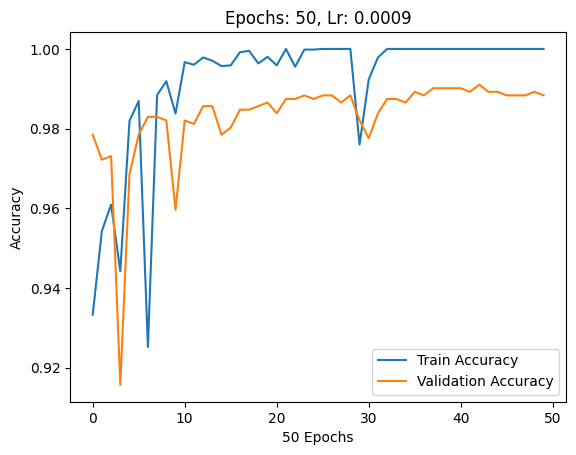

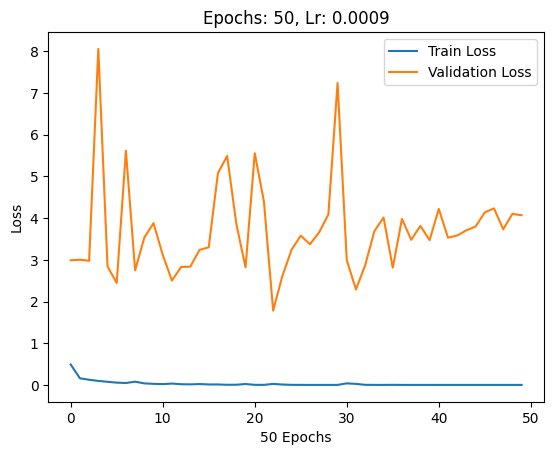

In [355]:
plot_acc_curves(Test5_loss_dict)
plot_loss_curves(Test5_loss_dict)

**So with this set of hyperparameters, we were able to get a very stable $98.8\%$ to $99.0\%$ accuracy on the validation set.**

In [399]:
# Sanity check for next part
# Create a Dataset of only spam validation examples
train_spam = torchtext.legacy.data.Dataset(
    [e for e in train.examples if e.label == 1],
    test.fields)

train_spam_iter = torchtext.legacy.data.BucketIterator(train_spam,
                                                       batch_size=32,
                                                       # to minimize padding
                                                       sort_key=lambda x: len(
                                                           x.sms),
                                                       sort_within_batch=True,        # sort within each batch
                                                       repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
train_nospam = torchtext.legacy.data.Dataset(
    [e for e in train.examples if e.label == 0],
    test.fields)

train_nospam_iter = torchtext.legacy.data.BucketIterator(train_nospam,
                                                         batch_size=32,
                                                         # to minimize padding
                                                         sort_key=lambda x: len(
                                                             x.sms),
                                                         sort_within_batch=True,        # sort within each batch
                                                         repeat=False)                  # repeat the iterator for many epochs
train_spam_acc = get_accuracy(
    Test5_model, train_spam_iter, len(text_field.vocab.itos), "cuda:0")
train_nospam_acc = get_accuracy(
    Test5_model, train_nospam_iter, len(text_field.vocab.itos), "cuda:0")
train_acc = get_accuracy(Test5_model, train_iter,
                         len(text_field.vocab.itos), "cuda:0")


c:\ProgramData\Anaconda3\envs\pytorch-torchtext\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
c:\ProgramData\Anaconda3\envs\pytorch-torchtext\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [393]:
print(len(train_spam), len(train_nospam), train_spam_acc.cpu().numpy(),
      train_nospam_acc.cpu().numpy(), train_acc.cpu().numpy())


3150 2893 0.99999994 1.0 1.0


In [398]:
train_spam_sanity_example = train_spam[10]
train_spam_sanity = "".join([x for x in train_spam_sanity_example.sms])

with torch.no_grad():
    sms = torch.tensor([text_field.vocab.stoi[x] for x in train_spam_sanity]).unsqueeze(0)
    data_processed = ident[sms].to("cuda:0")
    pred = Test5_model(data_processed)
    pred = nn.functional.sigmoid(pred).reshape(-1)
    pred_class = (pred>=0.5).float()
    print(float(pred.cpu().numpy()), int(pred_class))

1.4188478170140684e-09 0


c:\ProgramData\Anaconda3\envs\pytorch-torchtext\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [359]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in val.examples if e.label == 1],
    val.fields)

val_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam,
                                                     batch_size=32,
                                                     # to minimize padding
                                                     sort_key=lambda x: len(
                                                         x.sms),
                                                     sort_within_batch=True,        # sort within each batch
                                                     repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in val.examples if e.label == 0],
    val.fields)

val_nospam_iter = torchtext.legacy.data.BucketIterator(valid_nospam,
                                                     batch_size=32,
                                                     # to minimize padding
                                                     sort_key=lambda x: len(
                                                         x.sms),
                                                     sort_within_batch=True,        # sort within each batch
                                                     repeat=False)                  # repeat the iterator for many epochs

val_spam_acc = get_accuracy(model, val_spam_iter, len(text_field.vocab.itos), "cuda:0")
val_nospam_acc = get_accuracy(model, val_nospam_iter, len(text_field.vocab.itos), "cuda:0")
val_acc = get_accuracy(model, val_iter, len(text_field.vocab.itos), "cuda:0")

c:\ProgramData\Anaconda3\envs\pytorch-torchtext\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [360]:
print(val_spam_acc.cpu().numpy(), val_nospam_acc.cpu().numpy(), val_acc.cpu().numpy())

0.91891897 0.99069285 0.9856502


The false positive rate was the complement of the accuracy on the no-spam validation data subset, $1-0.99069285=0.0093071500<1\%$, since these were the wrongly classified as spam examples (predicted as spam but aren't). The false negative rate was the complement of the accuracy on the spam validation data subset, $1-0.91891897=0.08108103 \approx 8\%$, since these were the wrongly classified as not spam examples (predicted as not spam but are). 

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

False positive means that we mistakenly classify a non-spam example as a spam text, while false negative means that we mistakenly classify a spam example as not spam. So the impact of a false positive may be that the user misses some text, which is possibly important, while the impact of a false negative is that a spam text is classified as safe, where the spam text could have dangerous content like phishing links. While the exact impact of a false positive versus false negative is not immediately and precisely clear without examining the "average" (or even distribution if possible) false positive versus false negative, generally extreme cases like phishing links could be more dangerous as being marked "safe" (not spam) than just having the user check their spam folder perodically. 

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [361]:
test_acc = get_accuracy(Test5_model, test_iter, len(text_field.vocab.itos), "cuda:0")

In [362]:
print(f"Test Accuracy: {test_acc.cpu().numpy()}")

Test Accuracy: 0.9865350127220154


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [364]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                                     batch_size=32,
                                                     # to minimize padding
                                                     sort_key=lambda x: len(
                                                         x.sms),
                                                     sort_within_batch=True,        # sort within each batch
                                                     repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_nospam_iter = torchtext.legacy.data.BucketIterator(test_nospam,
                                                     batch_size=32,
                                                     # to minimize padding
                                                     sort_key=lambda x: len(
                                                         x.sms),
                                                     sort_within_batch=True,        # sort within each batch
                                                     repeat=False)                  # repeat the iterator for many epochs

test_spam_acc = get_accuracy(Test5_model, test_spam_iter, len(text_field.vocab.itos), "cuda:0")
test_nospam_acc = get_accuracy(Test5_model, test_nospam_iter, len(text_field.vocab.itos), "cuda:0")

In [365]:
print(test_spam_acc.cpu().numpy(), test_nospam_acc.cpu().numpy(), test_acc.cpu().numpy())

0.90604025 0.995855 0.986535


The false positive rate was the complement of the accuracy on the no-spam validation data subset, $1-0.995855=0.0041450000<1\%$, since these were the wrongly classified as spam examples (predicted as spam but aren't). The false negative rate was the complement of the accuracy on the spam validation data subset, $1-0.90604025=0.09395975 \approx 9\%$, since these were the wrongly classified as not spam examples (predicted as not spam but are). 

### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [400]:
msg = "machine learning is sooo cool!"
len(list(msg))

30

In [401]:
with torch.no_grad():
    sms = torch.tensor([text_field.vocab.stoi[x] for x in msg]).unsqueeze(0)
    data_processed = ident[sms].to("cuda:0")
    pred = Test5_model(data_processed)
    pred = nn.functional.sigmoid(pred).reshape(-1)
    print(float(pred.cpu().numpy()))


0.9999862909317017


The model predicts a greater than 99.99% probability that `msg` is not-spam (note that the `LabelField` maps the `spam` label to 0 because I left the vocabulary flag on). So the probability here is the conditional probability that the sms `msg` is not spam. **Thus on the contrary, there is a $1-0.9999862909317017 = 0.0000137091\%$ probability that the message is spam as predicted by the model.**

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

As we can see from the model results, using modern architectures, spam classification with a high accuracy and low false positive/negative rate is very achievable. This is probably because spam messages almost always have some tells about them since they are trying to get you to often do something monetary. Consider the two spam sms messages: 

`Get the official ENGLAND poly ringtone or colour flag on yer mobile for tonights game! Text TONE or FLAG to 84199. Optout txt ENG STOP Box39822 W111WX £1.50`

`8007 25p 4 Alfie Moon's Children in Need song on ur mob. Tell ur m8s. Txt TONE CHARITY to 8007 for nokias or POLY CHARITY for polys :zed 08701417012 profit 2 charity`

In both cases, words like "profit" and "£1.50" are fairly obvious clues that these are spam messages. In other words, there are semantic clues to spam messages. So on a more theoretical level, if we were to perform maximum likelihood estimation (e.g., use a `BCEWithLogitsLoss` for training), then it follows that our model weights should capture the semantical meanings. This would be in contrast to tasks like generative modelling, where the goal is to learn an entire distribution, an often intractable task.

So as a baseline model, since there are easy "tells" for when a text is spam, we could even go with relatively (in comparison to RNNs) parsimonious ensemble tree models, e.g., XGBoost or Adaboost. This would be trained similarly to a neural network and the hyperparameter tuning process could be the same. The training objective would be to find the best possible splits across characters or words that best minimize some criterion like Gini impurity or entropy. In the case of a tree-based baseline model, we may opt for the word as features since that would help keep dimensionality low and result in needing a lower tree depth (less splits needed to get a good classification of sms). Ensemble models (e.g., those that implement majority voting via boosting and bootstrap aggregation) are usually quite powerful and actually win a lot of Kaggle competitions, also they have the benefit of being quick to train and infer on usually. Thus, we could have a fairly "strong" baseline model that is advantageous over a "weak" baseline model (some neural network with a single hidden layer), which could give us a false sense of ability for the RNN model. 